# Time to get your hands dirty! The transient Universe

## Tasks

1. Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoscedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2. One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$$
y = b, \quad \text{for } t < t_0
$$

$$
y = b + A \exp[-\alpha (t - t_0)], \quad \text{for } t \geq t_0
$$

where \( b \) is the background amplitude, \( A \) is the burst amplitude, \($t_0$) is the burst epoch, and \($\alpha$) encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model.  
*Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now \( x \) is time, and the polynomial model is now the burst model.*

3. Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of: 
$$
\{b, A, t_0, \alpha\}
$$

You must decide on how many samples are appropriate for running your MCMC.  
For your priors, make them

$$
b \in \text{Uniform}[0, 50], \quad A \in \text{Uniform}[0, 50], \quad t_0 \in \text{Uniform}[0, 100], \quad \ln \alpha \in \text{Uniform}[-5, 5]
$$

(careful: uniform in \( $\ln(\alpha)$), not \( $\alpha$))



4. Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5. Make a corner plot of the 4-D parameter space, with labels, [68, 95]% credible levels and quantiles, and titles.

6. Now choose **100** samples randomly from your burned, thinned chain and plot the **100** corresponding burst time-series on a figure along with the original data. You may want to choose a transparent linestyle for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7. For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance,

$$
t_0 = X^{+Y}_{-Z}
$$


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import emcee
import corner

In [2]:
data=np.load("transient.npy")
time=data[:,0]# first column: time
flux = data[:, 1]  # second column: flux
error = data[:, 2]  # third column: uncertainties

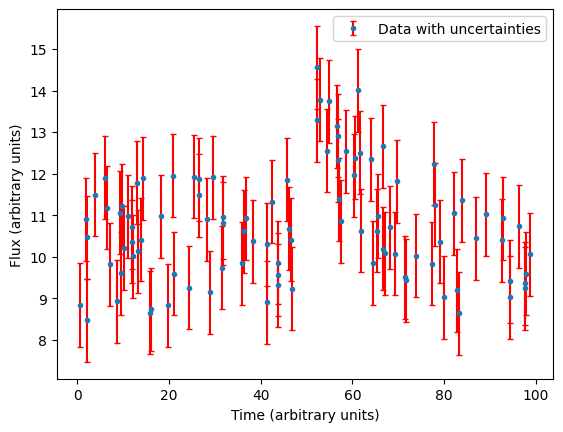

In [3]:
plt.errorbar(time,flux, yerr=error,fmt='.', label='Data with uncertainties', ecolor='red', capsize=2)
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Flux (arbitrary units)')
plt.legend()
plt.show()

In [4]:
# definition of the burst model:costant before t0, exponential decay after
def model(t, parameters):
    b, A, alpha, t0 = parameters  
    y = np.zeros_like(t)
    for i in range(len(t)):
        if t[i] < t0:
            y[i] = b
        else:
            y[i] = b + A * np.exp(-alpha * (t[i] - t0))
    return y

#Compute loglikelihood
def loglikelihood(parameters,t,y_obs, sigma):
    y_model = model(t, parameters)
    return -0.5 * np.sum(((y_obs - y_model) / sigma)**2 + np.log(2 * np.pi * sigma**2))


In [5]:
#This represents your belief about the parameters before seeing any data.
def logprior(parameters):
    b, A, alpha, t0 = parameters
     # Uniform priors on b, A, t0 within given bounds; uniform prior on ln(alpha) 
    if 0 <= b <= 50 and 0 <= A <= 50 and 0 <= t0 <= 100 and np.exp(-5) < alpha < np.exp(5):
        return np.log(1 / (50 * 50 * 100 * 10*alpha))  #P(alpha)=P(log-alpha)d(log-alpha)/d(alpha)
    return -np.inf


def logposterior(parameters, t, y_obs, sigma):
    prior_value = logprior(parameters)
    if not np.isfinite(prior_value): #isfinite = true only if it's a finite number
        return -np.inf
    y_model = model(t, parameters)
    return loglikelihood(parameters, t, y_obs, sigma) + prior_value



In [6]:
ndim=4 # Number of parameters in the model
nwalkers = 20 # Number of MCMC walkers
nsteps = 20000 # Total number of steps to run for each walker


# Initialize starting guesses for parameters based on the data
b_initial = np.median(flux) # Background level estimated as median of the observed flux
A_initial = np.max(flux) - b_initial # Burst amplitude estimated from flux range
alpha_initial = 0.1
t0_initial =50

initial = [b_initial, A_initial, alpha_initial, t0_initial]
# Create initial positions for each walker by adding small random perturbations
# This helps walkers explore different parts of parameter space
pos=initial + (1e-2)*np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(time, flux, error))
sampler.run_mcmc(pos, nsteps) # Run MCMC

print("done")

done


Text(0.5, 0, 'step number')

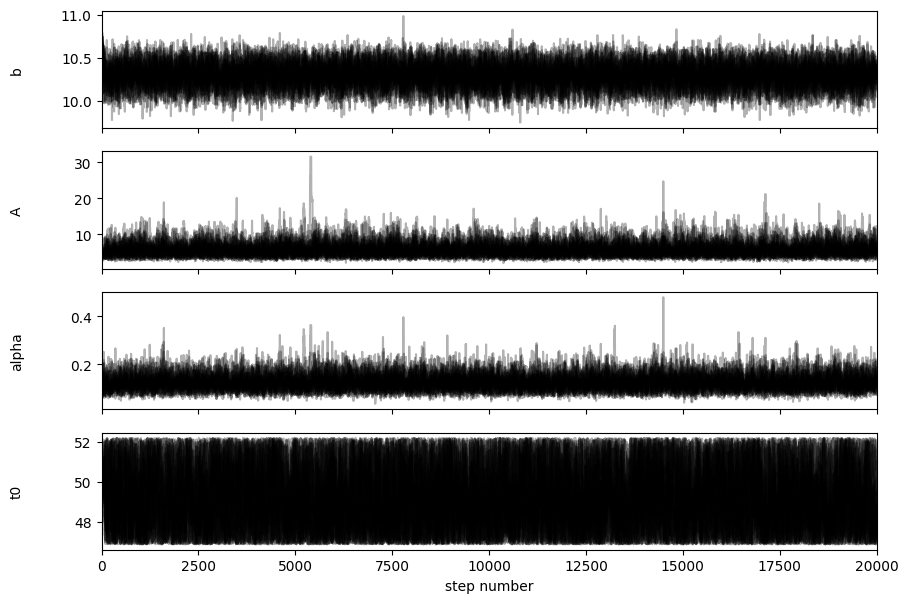

In [7]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain() # Extract the MCMC chains from the sampler
labels = ["b","A", "alpha", "t0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3) # for each parameter plot the trace of all walker
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [8]:
autocor_time=sampler.get_autocorr_time() # Calculate the autocorrelation time for each parameter
print(autocor_time)
# Get flattened samples, discarding burn-in and thinning by the max autocorr time 
flat_samples = sampler.get_chain(discard=3*int(max(autocor_time)), thin=int(max(autocor_time)), flat=True)
print(flat_samples.shape) #(nsamples_indipendet, n_parameters)

[57.1547077  80.29851236 69.44480547 79.2977167 ]
(4940, 4)


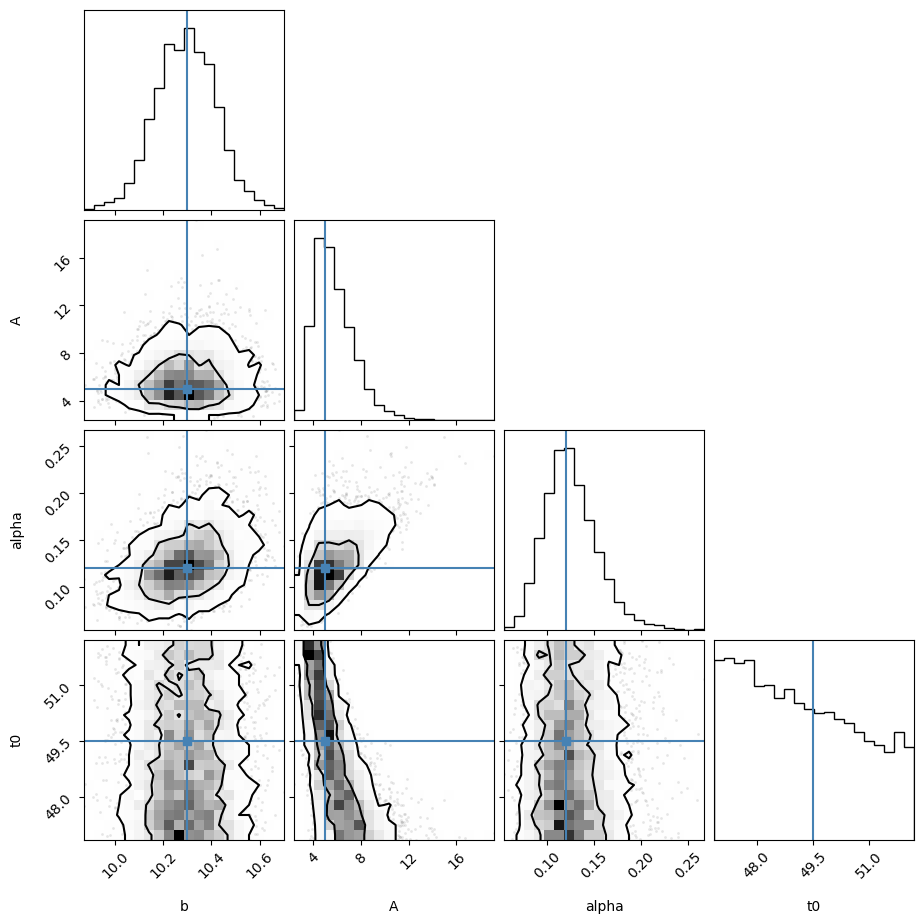

In [9]:
fig = corner.corner(flat_samples, labels=labels, levels=[0.68,0.95],truths=[10.3,5,0.12,49.5]) # Create a corner plot of the posterior samples 

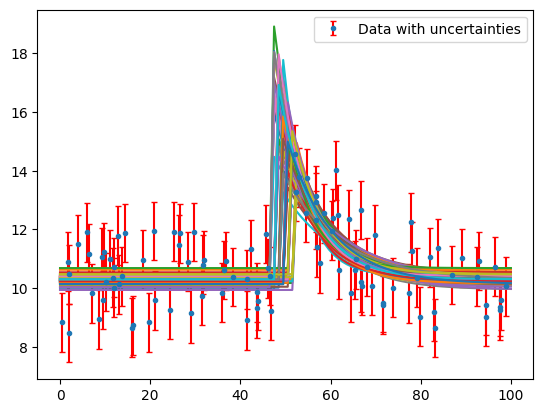

In [10]:
#Select 100 samples from the posterior distribution
# For each sample, compute the model prediction and plot it
sample=flat_samples[:100]
plt.errorbar(time,flux, yerr=error,fmt='.', label='Data with uncertainties', ecolor='red', capsize=2)
tgrid=np.linspace(0,100,100)
y=[]
for i in range(100):
    y.append(model(tgrid, sample[i])) # Evaluate the model at the given time points for each of the 100 posterior samples
    plt.plot(tgrid, y[i])

plt.legend()
plt.show()


In [11]:
# Compute median and 5th, 95th percentiles of the posterior samples for each parameter
medians = np.median(flat_samples, axis=0)
percentiles_5 = np.percentile(flat_samples, 5, axis=0)
percentiles_95 = np.percentile(flat_samples, 95, axis=0)

param_names = ['b', 'A', 'alpha', 't0']

for param_name, median, p5, p95 in zip(param_names, medians, percentiles_5, percentiles_95):
    print(f"{param_name} median: {median:.4f} (+{p95 - median:.4f} / -{median - p5:.4f})")


b median: 10.2942 (+0.1964 / -0.1959)
A median: 5.4168 (+3.4714 / -1.7941)
alpha median: 0.1226 (+0.0536 / -0.0381)
t0 median: 49.0225 (+2.7841 / -1.9582)


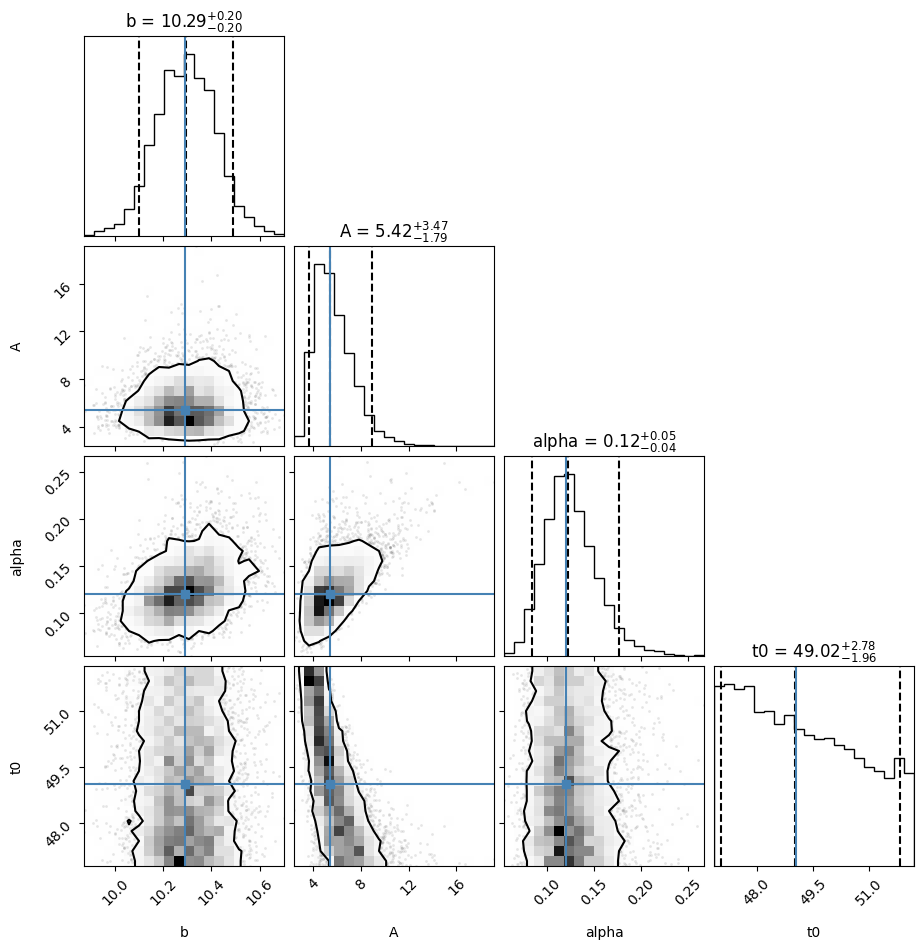

In [12]:
# Create a corner plot to visualize the posterior distributions and parameter correlations
flat_samples = sampler.get_chain(discard=3*int(max(autocor_time)), thin=int(max(autocor_time)), flat=True)
fig = corner.corner(flat_samples, 
                    labels=labels,  
                    quantiles=[0.05, 0.5, 0.95],  
                    show_titles=True,  
                    title_kwargs={"fontsize": 12},  
                    truths=[10.29,5.43,0.12,49.04],  
                    levels=[0.9]) 

plt.show()
